### General setup of session (apart from startup.jl)

In [1]:
include("hybrid_mr.jl")
include("../JMR_Base/MRstat.jl")
include("../JMR_Base/Misc.jl")
GLMakie.activate!(;float=true)
update_theme!(fontsize=2 * 14)

### Define the hybrid model structure

In [2]:
struct FluxPartModel_Q10
    RUE_chain::Flux.Chain
    RUE_predictors::AbstractArray{Symbol}
    Rb_chain::Flux.Chain
    Rb_predictors::AbstractArray{Symbol}
    Q10
end

function FluxPartModel_Q10(RUE_predictors::AbstractArray{Symbol}, Rb_predictors::AbstractArray{Symbol}, Q10=[1.5f0])
    RUE_ch = chain4RUEfun(length(RUE_predictors))
    Rb_ch = chain4Rbfun(length(Rb_predictors))
    FluxPartModel_Q10(RUE_ch, RUE_predictors, Rb_ch, Rb_predictors, Q10)
end

chain4RUEfun(nInVar) = Flux.Chain(
    BatchNorm(nInVar, affine=true),
    Dense(nInVar => 15, relu),
    #GRU(5 => 5),
    #Dense(12 => 12, σ), 
    Dense(15 => 1, σ),
)
chain4Rbfun(nInVar) = Flux.Chain(
    BatchNorm(nInVar, affine=true),
    Dense(nInVar => 15, relu),
    #GRU(5 => 5),
    #Dense(9 => 5, σ), 
    Dense(15 => 1, σ),
)
  
function (m::FluxPartModel_Q10)(x)

    # RUE_input4Chain = vars2matrix(x, m.RUE_predictors) #mapreduce(v -> x[v], hcat, m.RUE_predictors) |> transpose
    # Rb_input4Chain = vars2matrix(x, m.Rb_predictors) #mapreduce(v -> x[v], hcat, m.Rb_predictors) |> transpose
    # RUE = 1f0 * vec(m.RUE_chain(RUE_input4Chain)) ## 0.1 to make GPP between 0 and 100
    # GPP = reshape(x.SW_IN .* RUE ./ 12.011, 1, :)
    # Rb = 100f0 * vec(m.Rb_chain(Rb_input4Chain)) ## 100 to make Rb between 0 and 100
    # Reco = @c Rb .* m.Q10[1] .^ (0.1f0(x.TA .- 15.0f0)) reshape(1, :)
    # return Reco - GPP

    res = m(x, :infer)
    return reshape(res.RECO - res.GPP, 1, :)
end

function (m::FluxPartModel_Q10)(x, mode::Symbol)

    if mode == :infer
        RUE_input4Chain = vars2matrix(x, m.RUE_predictors) #mapreduce(v -> x[v], hcat, m.RUE_predictors) |> transpose
        Rb_input4Chain = vars2matrix(x, m.Rb_predictors) #mapreduce(v -> x[v], hcat, m.Rb_predictors) |> transpose
    
        RUE = 1f0 * vec(m.RUE_chain(RUE_input4Chain))
        GPP = reshape(x.SW_IN .* RUE ./ 12.011, 1, :)  # mol/g * g / J * J /s / m2 =mol m-2 s-1
        Rb = 100f0 * vec(m.Rb_chain(Rb_input4Chain))
        Reco = @c Rb .* m.Q10[1] .^ (0.1f0(x.TA .- 15.0f0)) reshape(1,:)

        return((; RUE, Rb, GPP=GPP |> vec, RECO=Reco |> vec, NEE=vec(Reco - GPP)))
    end

end

  # Call @functor to allow for training the custom model
    Flux.@functor FluxPartModel_Q10

### Load the data (experiment with changing Q10)

In [3]:
Q10 = 1.5f0
df = @chain "D:/markusr\\_FLUXNET\\AT-Neu.HH.csv" CSV.read(DataFrame, missingstring="NA") @transform(:NEE = coalesce(:NEE, :RECO_NT-:GPP_NT))
#select(df, names(df, Number))
transform!(df, names(df, Number) .=> ByRow(Float32), renamecols=false)
#subset(df, :doy => x-> 100 .< x .< 200)
#@subset! df 100 < :doy < 200
# mapcols(df) do col
#     eltype(col) === Int ? Float64.(col) : col
# end
df = @chain df begin 
    @transform :Rb_syn = max(:Rb_syn, 0.0f0)
    @transform :RECO_syn = :Rb_syn * Q10 ^ (0.1f0(:TA - 15.0f0))
    @transform :NEE_syn = :RECO_syn - :GPP_syn
end

dfs = @chain df begin 
    #@transform :NEE_SWin=@bycol mapwindow2(regBivar, :SW_IN, :NEE, 49)
    #unnest("NEE_SWin")
    #@transform :NEE_SWin=@bycol mapwindow2((x,y)->regBivar(Float64.(x),Float64.(y), quantreg), :SW_IN, :NEE, 49)
    #unnest("NEE_SWin")
    @transform {} = Float32({r"^NEE_SWin"})
   end

dt = dfs |> eachcol |> pairs |> NamedTuple;
dt=merge(dt, (; NEE_syn=dt.NEE_syn + 2f0 * randn(Float32, length(dt.NEE_syn))))



(siteID = InlineStrings.String7["AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu"  …  "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu", "AT-Neu"],
 DateTime = InlineStrings.String31["2005-01-01T00:15:00Z", "2005-01-01T00:45:00Z", "2005-01-01T01:15:00Z", "2005-01-01T01:45:00Z", "2005-01-01T02:15:00Z", "2005-01-01T02:45:00Z", "2005-01-01T03:15:00Z", "2005-01-01T03:45:00Z", "2005-01-01T04:15:00Z", "2005-01-01T04:45:00Z"  …  "2006-12-31T19:15:00Z", "2006-12-31T19:45:00Z", "2006-12-31T20:15:00Z", "2006-12-31T20:45:00Z", "2006-12-31T21:15:00Z", "2006-12-31T21:45:00Z", "2006-12-31T22:15:00Z", "2006-12-31T22:45:00Z", "2006-12-31T23:15:00Z", "2006-12-31T23:45:00Z"],
 doy = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  365.0, 365.0, 365.0, 365.0, 365.0, 365.0, 365.0, 365.0, 365.0, 365.0],
 timeofday = Float32[0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75  …  19.25, 19.75, 20.25, 2

### Ini concrete model instance and forward run for tech test

In [4]:
fpmod = FluxPartModel_Q10([:TA, :VPD], [:SW_POT_sm_diff, :SW_POT_sm],[2.0f0])
#fpmod = FluxPartModel_Q10([:TA, :VPD, :NEE_SWin_quantreg_slope], [:NEE_SWin_quantreg_inter, :TA],[1.0f0])
NEE = fpmod(dt) |> vec;
allinfo = fpmod(dt,:infer);
scatter(NEE)

### Train model and get best results

In [5]:
res=fit_df!(dt, nothing, :NEE_syn, (m, d) -> Flux.mse(m(d.x), d.y), model=fpmod, n_epoch=100, batchsize=480, opt=Adam(0.01), latents2record=[:Q10])
infer = res.bestModel(dt, :infer)


Epoch: 1, Train: 45.64409608224249, Vali: 46.69242238805718, Pat_cnt: 0


Epoch: 11, Train: 4.508124109802905, Vali: 4.582831482728924, Pat_cnt: 0

Epoch: 21, Train: 4.293312307698536, Vali: 4.382281816335879, Pat_cnt: 2


Epoch: 31, Train: 4.183877319653738, Vali: 4.27700262592765, Pat_cnt: 1


Epoch: 41, Train: 4.119775230244442, Vali: 4.230049533791348, Pat_cnt: 4


Epoch: 51, Train: 4.258544427391921, Vali: 4.362290674484457, Pat_cnt: 7


Epoch: 61, Train: 4.099099234587177, Vali: 4.219247186878488, Pat_cnt: 5


Epoch: 71, Train: 4.310889806859522, Vali: 4.414978866169929, Pat_cnt: 4


Epoch: 81, Train: 4.054256270920226, Vali: 4.174178327341979, Pat_cnt: 14


Epoch: 91, Train: 4.24811026529795, Vali: 4.36833181196055, Pat_cnt: 9


Final Plotting: Best model


ErrorException: `Makie.convert_arguments` for the plot type Lines{Tuple{Vector{Pair{Symbol, Vector{Float32}}}}} and its conversion trait PointBased() was unsuccessful.

The signature that could not be converted was:
::Vector{Pair{Symbol, Vector{Float32}}}

Makie needs to convert all plot input arguments to types that can be consumed by the backends (typically Arrays with Float32 elements).
You can define a method for `Makie.convert_arguments` (a type recipe) for these types or their supertypes to make this set of arguments convertible (See http://docs.makie.org/stable/documentation/recipes/index.html).

Alternatively, you can define `Makie.convert_single_argument` for single arguments which have types that are unknown to Makie but which can be converted to known types and fed back to the conversion pipeline.


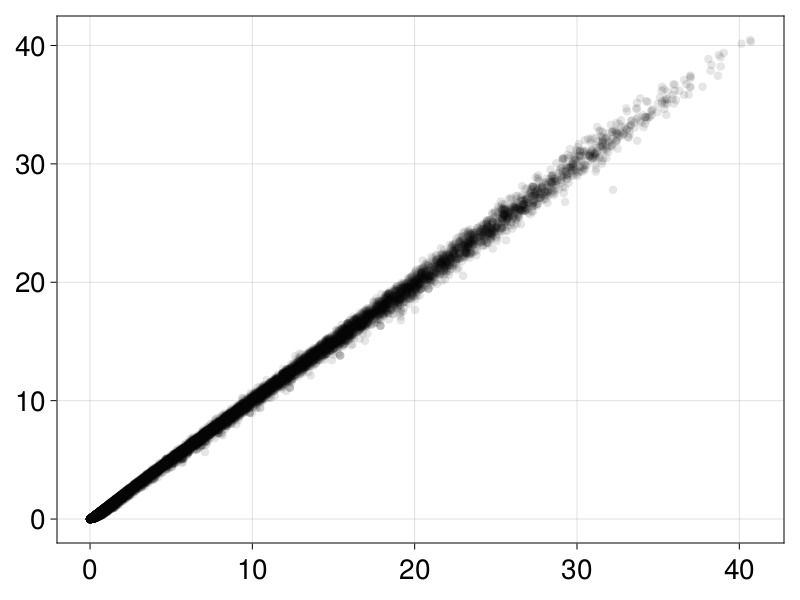

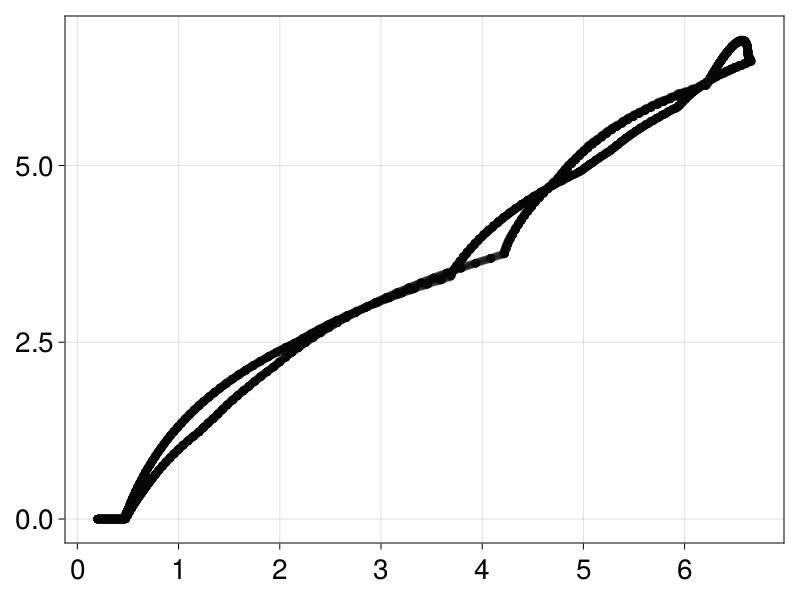

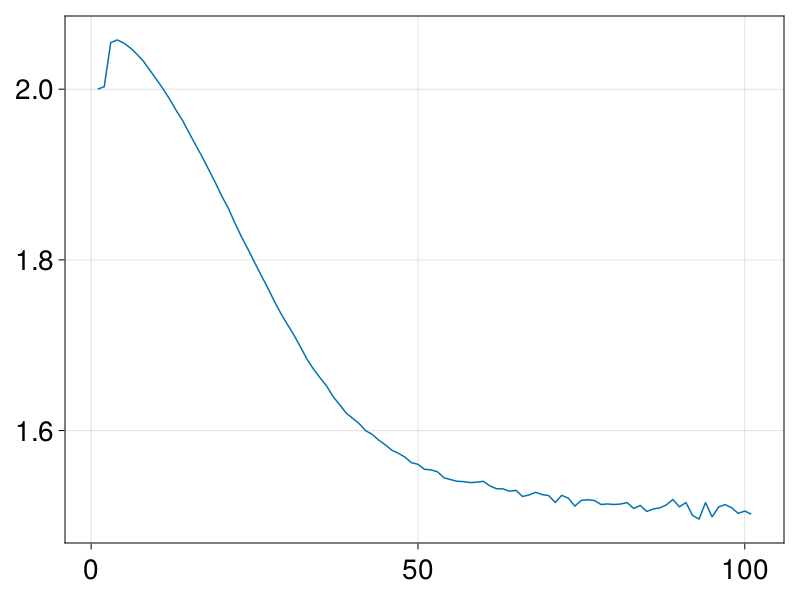

In [8]:
using CairoMakie
CairoMakie.activate!()
figs = [scatter(infer.GPP, dt.GPP_syn, color=(:black, 0.1)), scatter(infer.Rb, dt.Rb_syn, color=(:black, 0.1)), lines(res.trace_param[1].second)]
foreach(display, figs)
#fig=plotfit(res)

In [ ]:
#fig=plotfit(GLMakie.Screen(), res...)
lines(res.vali_losses)

In [ ]:
using CairoMakie
CairoMakie.activate!()
scatter(infer.GPP, dt.GPP_syn)